In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=12,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=12,
                                         shuffle=False, num_workers=2)

In [ ]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

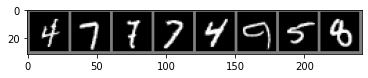

    4     7     7     7     4     9     5     8


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[:8]
labels = labels[:8]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join("%5s" % classes[labels[i]] for i in range(8)))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = self._make_layers([64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M'])
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 10),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

In [ ]:
vgg11 = Net()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg11.parameters(), lr=0.001, momentum=0.9)

In [ ]:
vgg11 = vgg11.to(device)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg11(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2500 == 2499:    # print every 2500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2500))
            running_loss = 0.0

print('Finished Training')

[1,  2500] loss: 0.215
[1,  5000] loss: 0.065
[2,  2500] loss: 0.044
[2,  5000] loss: 0.038
[3,  2500] loss: 0.027
[3,  5000] loss: 0.027
[4,  2500] loss: 0.019
[4,  5000] loss: 0.018
[5,  2500] loss: 0.017
[5,  5000] loss: 0.016
[6,  2500] loss: 0.011
[6,  5000] loss: 0.012
[7,  2500] loss: 0.007
[7,  5000] loss: 0.007
[8,  2500] loss: 0.006
[8,  5000] loss: 0.009
[9,  2500] loss: 0.006
[9,  5000] loss: 0.008
[10,  2500] loss: 0.005
[10,  5000] loss: 0.005
Finished Training


In [ ]:
PATH = './mnist_vgg11.pth'
torch.save(vgg11.state_dict(), PATH)

In [ ]:
vgg11 = Net()
vgg11.load_state_dict(torch.load(PATH))

if torch.cuda.is_available():
    vgg11.cuda()

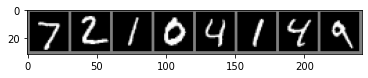

GroundTruth:    7   2   1   0   4   1   4   9
Predicted:      7   2   1   0   4   1   4   9


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images, labels = images[:8], labels[:8]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%3s' % classes[labels[i]] for i in range(8)))

images = images.to(device)
outputs = vgg11(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%3s' % classes[predicted[i]] for i in range(8)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg11(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 99 %
